In [1]:
# External libraries (not including Pytorch)
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F

# Included in Python standard library
import time
import math
import random
from itertools import combinations


%matplotlib inline

use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'

# Click on [ ] to run the hidden utils cells 

'Tesla T4'

## Generative Modelling and residual analysis (goodness-of-fit analysis)

The performance of the generative models can be checked via residual analysis where it is examined whether the generated sequences follow the theoretical distribution of the observed sequences by means of the time-change theorem for temporal point processes.


For this we consider the (timely ordered) time events $t_i$ each generated sequence $\xi = (t_1, \dots, t_m)$ and apply the time-change formula in order to yield the corresponding residuals
$$
\tau_i = \int_0^{t_i} \lambda^\ast(u) \, du
$$
where $\lambda^\ast$ denotes the conditional itensity function of the observed process. Assuming $\xi$ is sampled from the observed process, the time-change theorem then assesses that the residuals $\tau_i$ form a hom. Poisson process with rate parameter 1 and that, correspondingly, the increments $s_i = \tau_i - \tau_{i-1}$ come from an exponential distribution with rate parameter 1.

Consequently, we can formulate the residual analysis as the assessment of whether the increments $s_i$ follow a unit rate exponential distribution and reject the assumption that the generated sequences follow the theoretical distribution of the observed process if they significantly deviate from the unit rate exponential distribution.

Furthermore, using the formula $f(x) = 1 - \exp(-x)$ which transforms a unit rate exponential distribution into a uniform distribution on the interval $(0,1)$ we can perform a corresponding assessment between the transformed residuals $u_i = f(s_i)$ and the fit towards the uniform distribution on $(0,1)$.




### Inhom. Poisson process
In the following we consider an inhom. Poisson process on the interval $[0,30]$ as our theoretical distribution and compare the performance of the three generative models (WGAN, Sinkhorn, IPOT) via a residual analysis. The metric in all cases is the Xiao-metric.

In [6]:
DATA = 'inhom_poisson' # choose either: hawkes, inhom_poisson, inhom_poisson_gauss_kernels; specify distributions below
BATCH_SIZE = 32

## simulate real/observed data
max_T = 30 # maximum of time interval
SEQ_NUM = 2000 # number of samples in each noise process and observed process

sequences_real = []
intens_func = None
gauss_params = None


## specify intensity function of inhom. Poisson process (use sympy for symbolic function expression)
x = sy.Symbol("x")
intens_func = 1.1 + sy.sin(6*sy.pi*x/max_T - sy.pi/2)
sequences_real = create_inhom_poisson(func_expr=intens_func, n_samples=SEQ_NUM, max_T=max_T, min_seq_len=2)

# ## alternatively: specify intensity function of inhom. Poisson process via gauss kernels
# intensityPoissonGaussianKernels = IntensitySumGaussianKernel(k=2, centers=[5, 5], stds=[10, 20], coefs=[1, 1])
# intens_func = intens_func_from_gauss_params(gauss_params)
# sequences_real = create_inhom_poisson_gauss_kernels(intensityPoissonGaussianKernels, n_samples=SEQ_NUM, max_T=max_T)


## simulate noise samples which are transformed by the generator neural network
lambda0 = np.mean([len(item) for item in sequences_real])/max_T
sequences_noise = create_hom_poisson(mean=lambda0, n_samples=SEQ_NUM, max_T=max_T)


## initialize data iterators for batch-wise training
iterator_noise = PaddedDataIterator(sequences_noise, BATCH_SIZE, pad_elem = -1, sort_by_len=True)
iterator_real  = PaddedDataIterator(sequences_real, BATCH_SIZE, pad_elem = -1, sort_by_len=True)


## print summary statistics of the point process samples
max_seq_len = max([len(seq) for seq in sequences_noise+sequences_real])
avg_seq_len = np.round(np.mean([len(item) for item in sequences_real]), 2)


## Validation data
n_val_seqs = int(1000/(avg_seq_len)) # so that we have roughly 1000 points in all sequences combined
val_data = CreateValidationData(sequences_noise, sequences_real, n_seqs=n_val_seqs, device=device)


print("Number of sequences (with length > 2): %d (real process), %d (noise process)" %(len(sequences_real), len(sequences_noise)))
print("\nMaximal sequence length of real and noise process combined: %d" %(max_seq_len))
print("\nAverage number of points per sequence: ", avg_seq_len)

Number of sequences (with length > 2): 2000 (real process), 2000 (noise process)

Maximal sequence length of real and noise process combined: 52

Average number of points per sequence:  32.95


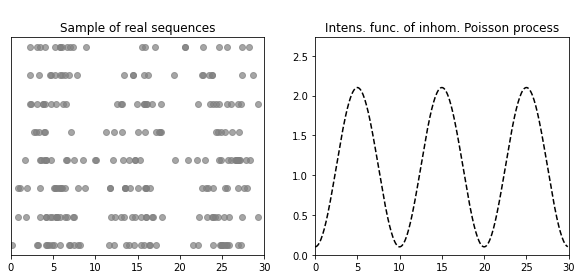

In [7]:
## plot sample of real sequences and the intensity function of the inhom. Poisson process
fig, axs = plt.subplots(1, 2, figsize=(10, 4), facecolor='w', edgecolor='k')

axs[0].set_xlim([0, max_T])
axs[0].set_yticks([])
axs[0].set_title("Sample of real sequences")
for i in range(min(8, SEQ_NUM)):
  axs[0].scatter(sequences_real[i], i*np.ones_like(sequences_real[i]), c="grey", alpha=0.7)

intens_func_f = sy.lambdify(x, intens_func, "numpy")
intens_func_x = np.arange(0, max_T, 0.1)
intens_func_y = intens_func_f(intens_func_x)
max_val = np.max(intens_func_y)
axs[1].set_xlim([0, max_T])
axs[1].set_ylim(0, 1.3*max_val)
axs[1].set_title("\nIntens. func. of inhom. Poisson process")
axs[1].plot(intens_func_x, intens_func_y, linestyle="--", alpha=1, color = 'black')

plt.show()

In [13]:
# Train WGAN model
LAMBDA_LP = 0.1 # regularization parameter (magnitude of Lipschitz penalty) in WGAN model

model_WGAN = WGAN(device=device, n_discr=5, hidden_dim=64, learn_rate=0.001, LAMBDA_LP=LAMBDA_LP)
model_WGAN.train(ITERS=5000, report_every=100,
                 iterator_real=iterator_real, iterator_noise=iterator_noise, max_T=max_T) # ~22min 30sec

Training Progress:    100 of   5000 || G_loss:   27.167 || D_loss:  -31.279
Training Progress:    200 of   5000 || G_loss:   54.099 || D_loss:  -90.562
Training Progress:    300 of   5000 || G_loss:   46.273 || D_loss:  -95.473
Training Progress:    400 of   5000 || G_loss:   63.987 || D_loss:  -84.940
Training Progress:    500 of   5000 || G_loss:   59.394 || D_loss: -117.342
Training Progress:    600 of   5000 || G_loss:   81.841 || D_loss: -133.694
Training Progress:    700 of   5000 || G_loss:  147.883 || D_loss:  -56.684
Training Progress:    800 of   5000 || G_loss:  123.243 || D_loss: -107.629
Training Progress:    900 of   5000 || G_loss: -135.197 || D_loss:    0.205
Training Progress:   1000 of   5000 || G_loss: -143.372 || D_loss:   -1.836
Training Progress:   1100 of   5000 || G_loss:  154.574 || D_loss:  -27.526
Training Progress:   1200 of   5000 || G_loss: -139.758 || D_loss:   -1.255
Training Progress:   1300 of   5000 || G_loss:   84.314 || D_loss:   27.646
Training Pro

In [10]:
# Train Sinkhorn model
beta = 30 # regularization parameter in Sinkhorn algorithm

model_Sinkhorn = Sinkhorn(device=device, hidden_dim=64, dropout_p=0.1, learn_rate=0.001,
                          n_sink=10, beta=beta, metric='xiao')
model_Sinkhorn.train(ITERS=2000, report_every=100,
                     iterator_real=iterator_real, iterator_noise=iterator_noise, max_T=max_T) # ~1min 25sec

Training Progress:    100 of   2000 || G_loss:  276.000 || G_loss (5-step moving avg):  276.000
Training Progress:    200 of   2000 || G_loss:  157.656 || G_loss (5-step moving avg):  216.828
Training Progress:    300 of   2000 || G_loss:  116.904 || G_loss (5-step moving avg):  183.520
Training Progress:    400 of   2000 || G_loss:   76.166 || G_loss (5-step moving avg):  156.682
Training Progress:    500 of   2000 || G_loss:   77.475 || G_loss (5-step moving avg):  140.840
Training Progress:    600 of   2000 || G_loss:   80.688 || G_loss (5-step moving avg):  101.778
Training Progress:    700 of   2000 || G_loss:   71.286 || G_loss (5-step moving avg):   84.504
Training Progress:    800 of   2000 || G_loss:   68.689 || G_loss (5-step moving avg):   74.861
Training Progress:    900 of   2000 || G_loss:   77.724 || G_loss (5-step moving avg):   75.172
Training Progress:   1000 of   2000 || G_loss:   67.337 || G_loss (5-step moving avg):   73.145
Training Progress:   1100 of   2000 || G

In [11]:
# Train IPOT model
beta = 30 # regularization parameter in IPOT algorithm

model_IPOT = IPOT(device=device, hidden_dim=64, dropout_p=0.1, learn_rate=0.001,
                  n_sink=1, n_ipot=10, beta=beta, metric='xiao')
model_IPOT.train(ITERS=2000, report_every=100,
                 iterator_real=iterator_real, iterator_noise=iterator_noise, max_T=max_T) # ~2min 44sec

Training Progress:    100 of   2000 || G_loss:  273.199 || G_loss (5-step moving avg):  273.199
Training Progress:    200 of   2000 || G_loss:  140.084 || G_loss (5-step moving avg):  206.642
Training Progress:    300 of   2000 || G_loss:   88.603 || G_loss (5-step moving avg):  167.295
Training Progress:    400 of   2000 || G_loss:   68.381 || G_loss (5-step moving avg):  142.567
Training Progress:    500 of   2000 || G_loss:   56.076 || G_loss (5-step moving avg):  125.268
Training Progress:    600 of   2000 || G_loss:   65.085 || G_loss (5-step moving avg):   83.646
Training Progress:    700 of   2000 || G_loss:   55.062 || G_loss (5-step moving avg):   66.641
Training Progress:    800 of   2000 || G_loss:   48.312 || G_loss (5-step moving avg):   58.583
Training Progress:    900 of   2000 || G_loss:   57.534 || G_loss (5-step moving avg):   56.414
Training Progress:   1000 of   2000 || G_loss:   57.751 || G_loss (5-step moving avg):   56.749
Training Progress:   1100 of   2000 || G

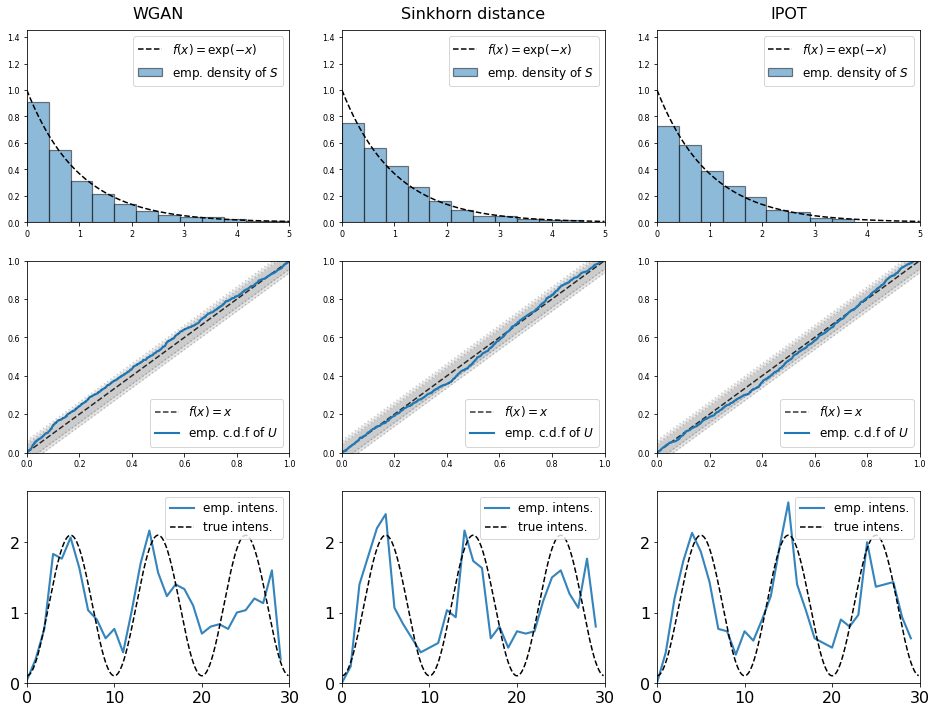

In [14]:
# perform residual analysis for all three generative models
# as theor. distribution is given by Poisson process we can also compare the emp. intensity given
# by the generated sequences with the true intensity given by the theor. Poisson process
generators=[model_WGAN.generator, model_Sinkhorn.generator, model_IPOT.generator]

# validation data (transformation by generators yields generated sequences which we use for residual analysis)
noise_tensor = val_data.batch_noise_seqs
noise_len_tensor = val_data.batch_noise_seqs_lens

plot_residual_analysis_compare_models(noise_tensor, noise_len_tensor, generators=generators, data_type=DATA, max_T=max_T, intens_func=intens_func, params=None, n_bins=12, conf_bands=True, plot_inten=True, size=4)

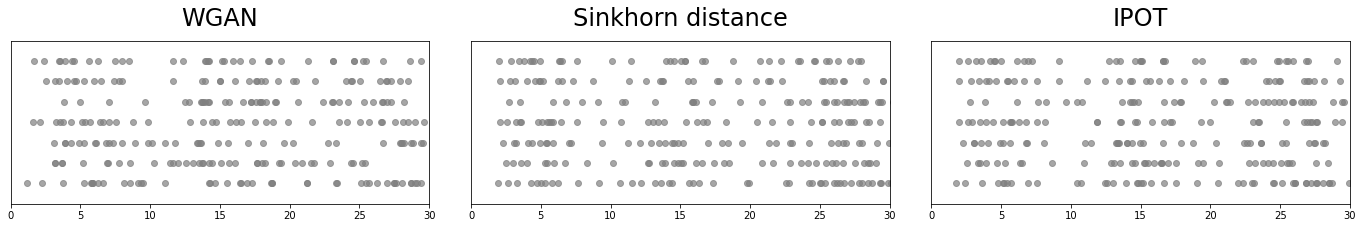

In [15]:
# generate for each model a sample of generated sequences
plot_gen_samples_compare_models(noise_tensor, noise_len_tensor, generators, max_T=max_T, size=3)

### Hawkes process
As second theoretical distibution we consider a Hawkes process and again compare the three generative models via the residual analysis. We let the point processes be constrained to the interval $[0,15]$ and use the Xiao-metric in all three models.

In [30]:
DATA = 'hawkes'
BATCH_SIZE = 32

## simulate real/observed data
max_T = 15 # maximum of time interval
SEQ_NUM = 2000 # number of samples of each point process

sequences_real = []
params_hawkes = {'alpha': 0.9,'mu': 0.6, 'omega': 1.0}
sequences_real = create_hawkes(params = params_hawkes, n_samples=SEQ_NUM, max_T=max_T)


## simulate noise samples
lambda0 = np.mean([len(item) for item in sequences_real])/max_T
sequences_noise = create_hom_poisson(mean=lambda0, n_samples=SEQ_NUM, max_T=max_T)


## initialize data iterators for batch-wise training
iterator_noise = PaddedDataIterator(sequences_noise, BATCH_SIZE, pad_elem = -1, sort_by_len=True)
iterator_real  = PaddedDataIterator(sequences_real, BATCH_SIZE, pad_elem = -1, sort_by_len=True)


## print summary statistics of the point process samples
max_seq_len = max([len(seq) for seq in sequences_noise+sequences_real])
avg_seq_len = np.round(np.mean([len(item) for item in sequences_real]), 2)


## Validation data
n_val_seqs = int(1000/(avg_seq_len)) # so that we have roughly 1000 points in all sequences combined
val_data = CreateValidationData(sequences_noise, sequences_real, n_seqs=n_val_seqs, device=device)


print("Number of sequences (with length > 2): %d (real process), %d (noise process)" %(len(sequences_real), len(sequences_noise)))
print("\nMaximal sequence length of real and noise process combined: %d" %(max_seq_len))
print("\nAverage number of points per sequence: ", avg_seq_len)

Number of sequences (with length > 2): 1717 (real process), 2000 (noise process)

Maximal sequence length of real and noise process combined: 235

Average number of points per sequence:  21.27


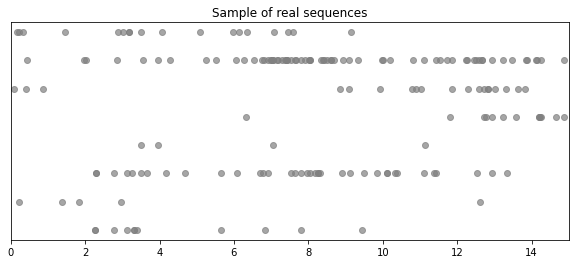

In [18]:
## plot sample of real/observed sequences
fig, axs = plt.subplots(1, figsize=(10, 4), facecolor='w', edgecolor='k')

axs.set_xlim([0, max_T])
axs.set_yticks([])
axs.set_title("Sample of real sequences")
for i in range(min(8, SEQ_NUM)):
  axs.scatter(sequences_real[i], i*np.ones_like(sequences_real[i]), c="grey", alpha=0.7)

plt.show()

In [19]:
# Train WGAN model
LAMBDA_LP = 0.1 # regularization parameter (magnitude of Lipschitz penalty) in WGAN model

model_WGAN = WGAN(device=device, n_discr=5, hidden_dim=64, learn_rate=0.001, LAMBDA_LP=LAMBDA_LP)
model_WGAN.train(ITERS=5000, report_every=100,
                 iterator_real=iterator_real, iterator_noise=iterator_noise, max_T=max_T) # ~16min 33sec

Training Progress:    100 of   5000 || G_loss:   51.337 || D_loss:  -63.207
Training Progress:    200 of   5000 || G_loss:  110.612 || D_loss: -130.625
Training Progress:    300 of   5000 || G_loss:   45.101 || D_loss: -124.702
Training Progress:    400 of   5000 || G_loss:  189.657 || D_loss: -161.414
Training Progress:    500 of   5000 || G_loss:  181.306 || D_loss: -135.484
Training Progress:    600 of   5000 || G_loss:  110.840 || D_loss:  -71.456
Training Progress:    700 of   5000 || G_loss:  269.890 || D_loss: -260.594
Training Progress:    800 of   5000 || G_loss:  297.782 || D_loss: -121.160
Training Progress:    900 of   5000 || G_loss:  143.672 || D_loss:  -21.151
Training Progress:   1000 of   5000 || G_loss:  315.589 || D_loss: -292.842
Training Progress:   1100 of   5000 || G_loss:  416.804 || D_loss: -418.350
Training Progress:   1200 of   5000 || G_loss:  208.684 || D_loss: -162.647
Training Progress:   1300 of   5000 || G_loss: -153.148 || D_loss:   30.063
Training Pro

In [20]:
# Train Sinkhorn model
beta = 30 # regularization parameter in Sinkhorn algorithm

model_Sinkhorn = Sinkhorn(device=device, hidden_dim=64, dropout_p=0.1, learn_rate=0.001,
                          n_sink=10, beta=beta, metric='xiao')
model_Sinkhorn.train(ITERS=2000, report_every=100,
                     iterator_real=iterator_real, iterator_noise=iterator_noise, max_T=max_T,
                     n_sink_TT=1, n_ipot_TT=10, beta_TT=max_T/20, algo_TT='ipot') # ~1min 15sec

Training Progress:    100 of   2000 || G_loss:  102.310 || G_loss (5-step moving avg):  102.310
Training Progress:    200 of   2000 || G_loss:   74.674 || G_loss (5-step moving avg):   88.492
Training Progress:    300 of   2000 || G_loss:   52.522 || G_loss (5-step moving avg):   76.502
Training Progress:    400 of   2000 || G_loss:   55.540 || G_loss (5-step moving avg):   71.262
Training Progress:    500 of   2000 || G_loss:   44.673 || G_loss (5-step moving avg):   65.944
Training Progress:    600 of   2000 || G_loss:   55.775 || G_loss (5-step moving avg):   56.637
Training Progress:    700 of   2000 || G_loss:   50.683 || G_loss (5-step moving avg):   51.839
Training Progress:    800 of   2000 || G_loss:   47.539 || G_loss (5-step moving avg):   50.842
Training Progress:    900 of   2000 || G_loss:   51.378 || G_loss (5-step moving avg):   50.010
Training Progress:   1000 of   2000 || G_loss:   89.899 || G_loss (5-step moving avg):   59.055
Training Progress:   1100 of   2000 || G

In [21]:
# Train IPOT model
beta = 30 # regularization parameter in IPOT algorithm

model_IPOT = IPOT(device=device, hidden_dim=64, dropout_p=0.1, learn_rate=0.001,
                  n_sink=1, n_ipot=10, beta=beta, metric='xiao')
model_IPOT.train(ITERS=2000, report_every=100,
                 iterator_real=iterator_real, iterator_noise=iterator_noise, max_T=max_T,
                 n_sink_TT=1, n_ipot_TT=10, beta_TT=max_T/20, algo_TT='ipot') # ~2min 53sec

Training Progress:    100 of   2000 || G_loss:   82.153 || G_loss (5-step moving avg):   82.153
Training Progress:    200 of   2000 || G_loss:   43.254 || G_loss (5-step moving avg):   62.704
Training Progress:    300 of   2000 || G_loss:   40.330 || G_loss (5-step moving avg):   55.246
Training Progress:    400 of   2000 || G_loss:   44.776 || G_loss (5-step moving avg):   52.628
Training Progress:    500 of   2000 || G_loss:   36.698 || G_loss (5-step moving avg):   49.442
Training Progress:    600 of   2000 || G_loss:   34.836 || G_loss (5-step moving avg):   39.979
Training Progress:    700 of   2000 || G_loss:   35.852 || G_loss (5-step moving avg):   38.498
Training Progress:    800 of   2000 || G_loss:   36.346 || G_loss (5-step moving avg):   37.701
Training Progress:    900 of   2000 || G_loss:   39.010 || G_loss (5-step moving avg):   36.548
Training Progress:   1000 of   2000 || G_loss:   49.240 || G_loss (5-step moving avg):   39.057
Training Progress:   1100 of   2000 || G

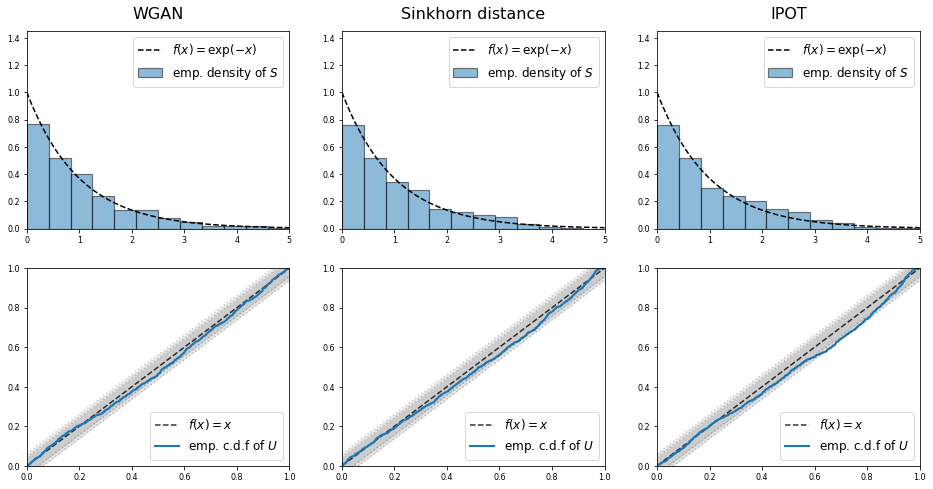

In [31]:
# perform residual analysis for all three generative models
generators=[model_WGAN.generator, model_Sinkhorn.generator, model_IPOT.generator]

# validation data (transformation by generators yields generated sequences which we use for residual analysis)
noise_tensor = val_data.batch_noise_seqs
noise_len_tensor = val_data.batch_noise_seqs_lens

plot_residual_analysis_compare_models(noise_tensor, noise_len_tensor, generators=generators, data_type="hawkes", max_T=max_T, params=params_hawkes, n_bins=12, conf_bands=True, plot_inten=False, size=4)

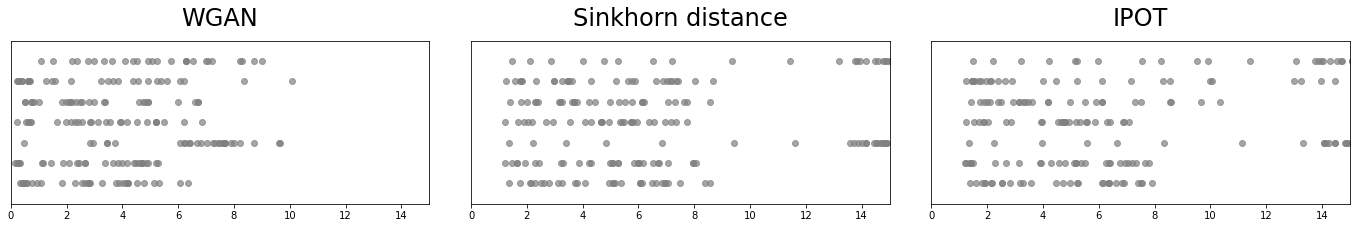

In [32]:
# generate for each model a sample of generated sequences
plot_gen_samples_compare_models(noise_tensor, noise_len_tensor, generators, max_T=max_T, size=3)

### Further analysis
We choose the IPOT model as the generative model on which we apply further analysis. The further analysis consists of two parts.

First, we analyse the influence of the sequence metric (Xiao-metric or TT-metric) in the training of the generative model by systematically choosing the mean intensity of the noise process to be smaller, bigger or equal the mean intensity of the observed/real process. After the training we assess the empirical intensity of the generated sequences where we use an inhom. Poisson process as the real process. 

Secondly, we check our model for overfitting. A common approach in generative models is to assess how close the generated data is to the observed data in terms of an appropiate metric. If the generated sequences merely copy the sample of observed sequences rather than representing an authentic new sample of observed sequences, this would account for an overfitting.

In [33]:
DATA = 'inhom_poisson_gauss_kernels' # choose either: hawkes, inhom_poisson, inhom_poisson_gauss_kernels; specify distributions below
BATCH_SIZE = 32

## simulate real/observed data
max_T = 200 # maximum of time interval
SEQ_NUM = 2000 # number of samples of each point process

gauss_params = dict()
gauss_params['coef'] = [10, 2]  # sum of these numbers ~ average number of points per sequence
gauss_params['center'] = [50, 100]
gauss_params['std'] = [40, 1000]  # high std in second kernel in order to ensure intensity is not too close to 0 on interval

n_kernels = len(gauss_params['coef'])
intensityPoissonGaussianKernels = IntensitySumGaussianKernel(k=2, centers=gauss_params['center'], stds=gauss_params['std'], coefs=gauss_params['coef'])
sequences_real = create_inhom_poisson_gauss_kernels(intensityPoissonGaussianKernels, n_samples=SEQ_NUM, max_T=max_T)


## simulate noise samples where the mean intensity of noise process varies in relation to real process
lambda0 = np.mean([len(item) for item in sequences_real])/max_T
seqs_noise_mean_intens_equal = create_hom_poisson(mean = lambda0, n_samples=SEQ_NUM, max_T=max_T)
seqs_noise_mean_intens_bigger = create_hom_poisson(mean = 1.3*lambda0, n_samples=SEQ_NUM, max_T=max_T)
seqs_noise_mean_intens_smaller = create_hom_poisson(mean = 0.7*lambda0, n_samples=SEQ_NUM, max_T=max_T)


## initialize data iterators for batch-wise training
iterator_noise_equal = PaddedDataIterator(seqs_noise_mean_intens_equal, BATCH_SIZE, pad_elem = -1, sort_by_len=True)
iterator_noise_bigger = PaddedDataIterator(seqs_noise_mean_intens_bigger, BATCH_SIZE, pad_elem = -1, sort_by_len=True)
iterator_noise_smaller = PaddedDataIterator(seqs_noise_mean_intens_smaller, BATCH_SIZE, pad_elem = -1, sort_by_len=True)
iterator_real  = PaddedDataIterator(sequences_real, BATCH_SIZE, pad_elem = -1, sort_by_len=True)

avg_seq_len = np.round(np.mean([len(item) for item in sequences_real]), 2)

## Validation data
n_val_seqs = int(1000/(avg_seq_len)) # so that we have roughly 1000 points in all sequences combined
val_data_noise_equal = CreateValidationData(seqs_noise_mean_intens_equal, sequences_real, n_seqs=n_val_seqs, device=device)
val_data_noise_bigger = CreateValidationData(seqs_noise_mean_intens_bigger, sequences_real, n_seqs=int(1.3*n_val_seqs), device=device)
val_data_noise_smaller = CreateValidationData(seqs_noise_mean_intens_smaller, sequences_real, n_seqs=int(0.7*n_val_seqs), device=device)

print("Average number of points per sequence (real sequences): ", avg_seq_len)
print("Average number of points per sequence (noise sequences with equal mean intensity): ", avg_seq_len)
print("Average number of points per sequence (noise sequences with bigger mean intensity): ", np.round(1.3*avg_seq_len, 2))
print("Average number of points per sequence (noise sequences with smaller intensity): ", np.round(0.7*avg_seq_len, 2))

Average number of points per sequence (real sequences):  9.18
Average number of points per sequence (noise sequences with equal mean intensity):  9.18
Average number of points per sequence (noise sequences with bigger mean intensity):  11.93
Average number of points per sequence (noise sequences with smaller intensity):  6.43


In [34]:
# Train IPOT model w.r.t. xiao or TT metric where intensity of noise process is equal to intensity of real process (default)
print("Train IPOT model using Xiao-metric and noise sequences with mean intensity equal to mean intensity of real sequences:")
model_IPOT_xiao_equal = IPOT(device=device, learn_rate=0.01,
                             n_sink=1, n_ipot=10, beta=200, metric='xiao')
model_IPOT_xiao_equal.train(ITERS=1000, report_every=200,
                            iterator_real=iterator_real, iterator_noise=iterator_noise_equal, max_T=max_T)

print("\nTrain IPOT model using T-metric and noise sequences with mean intensity equal to mean intensity of real sequences:")
model_IPOT_TT_equal = IPOT(device=device, learn_rate=0.01,
                           n_sink=1, n_ipot=10, beta=200, metric='TT')
model_IPOT_TT_equal.train(ITERS=1000, report_every=200,
                          iterator_real=iterator_real, iterator_noise=iterator_noise_equal, max_T=max_T,
                          n_sink_TT=1, n_ipot_TT=10, beta_TT=max_T/20, algo_TT='ipot')

Train IPOT model using Xiao-metric and noise sequences with mean intensity equal to mean intensity of real sequences:
Training Progress:    200 of   1000 || G_loss:  225.223 || G_loss (5-step moving avg):  225.223
Training Progress:    400 of   1000 || G_loss:  138.661 || G_loss (5-step moving avg):  181.942
Training Progress:    600 of   1000 || G_loss:  198.435 || G_loss (5-step moving avg):  187.440
Training Progress:    800 of   1000 || G_loss:  227.077 || G_loss (5-step moving avg):  197.349
Training Progress:   1000 of   1000 || G_loss:  124.932 || G_loss (5-step moving avg):  182.866

Train IPOT model using T-metric and noise sequences with mean intensity equal to mean intensity of real sequences:
Training Progress:    200 of   1000 || G_loss:  854.340 || G_loss (5-step moving avg):  854.340
Training Progress:    400 of   1000 || G_loss:  616.499 || G_loss (5-step moving avg):  735.420
Training Progress:    600 of   1000 || G_loss:  519.420 || G_loss (5-step moving avg):  663.42

In [35]:
# Train IPOT model w.r.t. xiao or TT metric where intensity of noise process is bigger than intensity of real process
print("Train IPOT model using Xiao-metric and noise sequences with mean intensity bigger than mean intensity of real sequences:")
model_IPOT_xiao_bigger = IPOT(device=device, learn_rate=0.01,
                              n_sink=1, n_ipot=10, beta=200, metric='xiao')
model_IPOT_xiao_bigger.train(ITERS=1000, report_every=200,
                             iterator_real=iterator_real, iterator_noise=iterator_noise_bigger, max_T=max_T)

print("\nTrain IPOT model using TT-metric and noise sequences with mean intensity bigger than mean intensity of real sequences:")
model_IPOT_TT_bigger = IPOT(device=device, learn_rate=0.01,
                            n_sink=1, n_ipot=10, beta=200, metric='TT')
model_IPOT_TT_bigger.train(ITERS=1000, report_every=200,
                           iterator_real=iterator_real, iterator_noise=iterator_noise_bigger, max_T=max_T,
                           n_sink_TT=1, n_ipot_TT=10, beta_TT=max_T/20, algo_TT='ipot')

Train IPOT model using Xiao-metric and noise sequences with mean intensity bigger than mean intensity of real sequences:
Training Progress:    200 of   1000 || G_loss:  342.919 || G_loss (5-step moving avg):  342.919
Training Progress:    400 of   1000 || G_loss:  264.373 || G_loss (5-step moving avg):  303.646
Training Progress:    600 of   1000 || G_loss:  245.308 || G_loss (5-step moving avg):  284.200
Training Progress:    800 of   1000 || G_loss:  172.337 || G_loss (5-step moving avg):  256.234
Training Progress:   1000 of   1000 || G_loss:  181.043 || G_loss (5-step moving avg):  241.196

Train IPOT model using TT-metric and noise sequences with mean intensity bigger than mean intensity of real sequences:
Training Progress:    200 of   1000 || G_loss: 1047.376 || G_loss (5-step moving avg): 1047.376
Training Progress:    400 of   1000 || G_loss: 1250.515 || G_loss (5-step moving avg): 1148.946
Training Progress:    600 of   1000 || G_loss:  830.179 || G_loss (5-step moving avg): 

In [37]:
# Train IPOT model w.r.t. xiao or TT metric where intensity of noise process is smaller than intensity of real process
print("Train IPOT model using Xiao-metric and noise sequences with mean intensity smaller than mean intensity of real sequences:")
model_IPOT_xiao_smaller = IPOT(device=device, learn_rate=0.01,
                               n_sink=1, n_ipot=10, beta=200, metric='xiao')
model_IPOT_xiao_smaller.train(ITERS=1000, report_every=200,
                              iterator_real=iterator_real, iterator_noise=iterator_noise_smaller, max_T=max_T)

print("\nTrain IPOT model using TT-metric and noise sequences with mean intensity bigger than mean intensity of real sequences:")
model_IPOT_TT_smaller = IPOT(device=device, learn_rate=0.01,
                             n_sink=1, n_ipot=10, beta=200, metric='TT')
model_IPOT_TT_smaller.train(ITERS=1000, report_every=200,
                            iterator_real=iterator_real, iterator_noise=iterator_noise_smaller, max_T=max_T,
                            n_sink_TT=1, n_ipot_TT=10, beta_TT=max_T/20, algo_TT='ipot')

Train IPOT model using Xiao-metric and noise sequences with mean intensity smaller than mean intensity of real sequences:
Training Progress:    200 of   1000 || G_loss:  253.753 || G_loss (5-step moving avg):  253.753
Training Progress:    400 of   1000 || G_loss:  301.360 || G_loss (5-step moving avg):  277.557
Training Progress:    600 of   1000 || G_loss:  309.125 || G_loss (5-step moving avg):  288.080
Training Progress:    800 of   1000 || G_loss:  269.172 || G_loss (5-step moving avg):  283.353
Training Progress:   1000 of   1000 || G_loss:  293.772 || G_loss (5-step moving avg):  285.437

Train IPOT model using TT-metric and noise sequences with mean intensity bigger than mean intensity of real sequences:
Training Progress:    200 of   1000 || G_loss:  499.937 || G_loss (5-step moving avg):  499.937
Training Progress:    400 of   1000 || G_loss:  501.417 || G_loss (5-step moving avg):  500.677
Training Progress:    600 of   1000 || G_loss:  516.073 || G_loss (5-step moving avg):

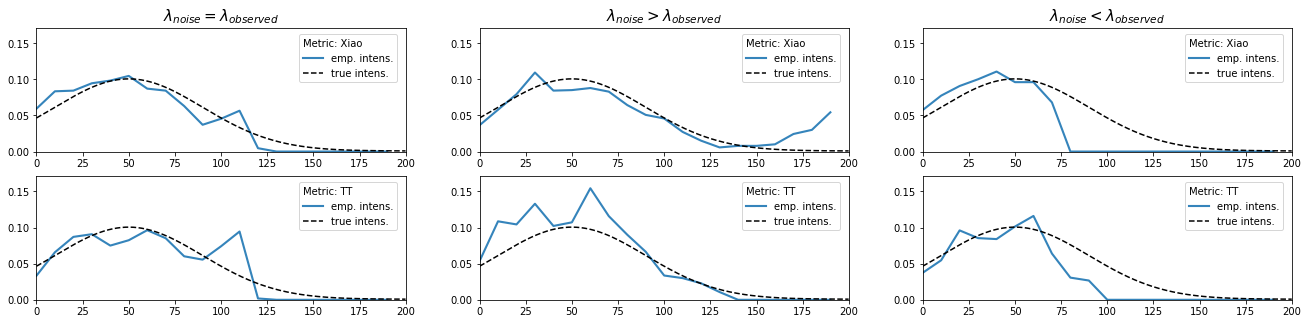

In [38]:
# compare trained IPOT models by assessing the empirical intensities of the generated sequences 
x = sy.Symbol("x")
intens_func = intens_func_from_gauss_params(gauss_params)

# order in the lists w.r.t. equal/bigger/smaller and xiao/TT has to be hold for the plotting
val_data_list = [val_data_noise_equal, val_data_noise_bigger, val_data_noise_smaller]
generators = [model_IPOT_xiao_equal.generator, model_IPOT_TT_equal.generator,
              model_IPOT_xiao_bigger.generator, model_IPOT_TT_bigger.generator,
              model_IPOT_xiao_smaller.generator, model_IPOT_TT_smaller.generator]

plot_metric_comparision_vary_noise_mean_intens(
    val_data_list=val_data_list,
    generators=generators,
    intens_func=intens_func,
    max_T=max_T,
    size=2.5)

In [39]:
## train a new generative model (IPOT) to see if the model is overfitting
## use a Hawkes process for the simulation of the real data

DATA = 'hawkes'
BATCH_SIZE = 32

## simulate real/observed data
max_T = 15 # maximum of time interval
SEQ_NUM = 2000 # number of samples of each point process

sequences_real = []
params_hawkes = {'alpha': 0.9,'mu': 0.6, 'omega': 1.0}
sequences_real = create_hawkes(params = params_hawkes, n_samples=SEQ_NUM, max_T=max_T)

## simulate noise samples
lambda0 = np.mean([len(item) for item in sequences_real])/max_T
sequences_noise = create_hom_poisson(mean=lambda0, n_samples=SEQ_NUM, max_T=max_T)

## initialize data iterators for batch-wise training
iterator_noise = PaddedDataIterator(sequences_noise, BATCH_SIZE, pad_elem = -1, sort_by_len=True)
iterator_real  = PaddedDataIterator(sequences_real, BATCH_SIZE, pad_elem = -1, sort_by_len=True)

## Validation data
n_val_seqs = int(1000/(avg_seq_len)) # so that we have roughly 1000 points in all sequences combined
val_data = CreateValidationData(sequences_noise, sequences_real, n_seqs=n_val_seqs, device=device)

## Train IPOT model
model_IPOT = IPOT(device=device, learn_rate=0.01,
                  n_sink=1, n_ipot=10, beta=max_T, metric='xiao')
model_IPOT.train(ITERS=1500, report_every=100,
                 iterator_real=iterator_real, iterator_noise=iterator_noise, max_T=max_T)

Training Progress:    100 of   1500 || G_loss:   46.221 || G_loss (5-step moving avg):   46.221
Training Progress:    200 of   1500 || G_loss:   36.740 || G_loss (5-step moving avg):   41.481
Training Progress:    300 of   1500 || G_loss:   34.047 || G_loss (5-step moving avg):   39.003
Training Progress:    400 of   1500 || G_loss:   37.710 || G_loss (5-step moving avg):   38.679
Training Progress:    500 of   1500 || G_loss:   39.200 || G_loss (5-step moving avg):   38.784
Training Progress:    600 of   1500 || G_loss:   56.239 || G_loss (5-step moving avg):   40.787
Training Progress:    700 of   1500 || G_loss:   48.981 || G_loss (5-step moving avg):   43.235
Training Progress:    800 of   1500 || G_loss:   34.107 || G_loss (5-step moving avg):   43.248
Training Progress:    900 of   1500 || G_loss:   46.651 || G_loss (5-step moving avg):   45.036
Training Progress:   1000 of   1500 || G_loss:   36.491 || G_loss (5-step moving avg):   44.494
Training Progress:   1100 of   1500 || G

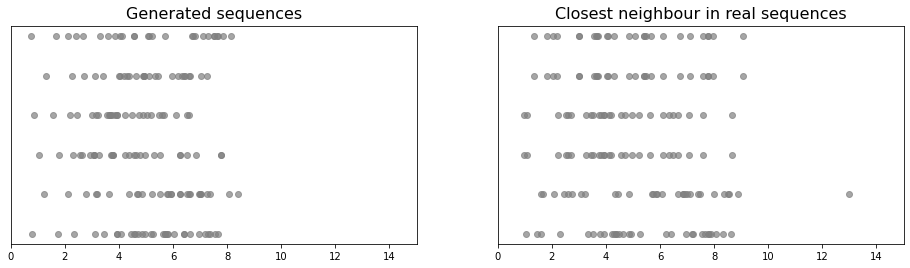

In [40]:
# check for overfitting by comparing each generated sequence to its closest neighbour (w.r.t. Xiao-metric) in set of observed sequences
noise_tensor = val_data.batch_noise_seqs
noise_len_tensor = val_data.batch_noise_seqs_lens

gen_seqs = retrieve_seqs_from_gen(noise_tensor, noise_len_tensor, model_IPOT.generator)

plot_min_xiao_dist_gen_to_obs(gen_seqs, sequences_real, max_T=max_T, size=4)